# Talhão 1

In [39]:
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
from pykrige.rk import RegressionKriging
import warnings
from scipy.stats import t
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.interpolate import RegularGridInterpolator
from sklearn.neighbors import KNeighborsRegressor
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
# import random forest
from sklearn.ensemble import RandomForestRegressor


warnings.filterwarnings('ignore')


def calculate_statistics(dataframe, confidence_level=0.95):
    """
    Calculate descriptive statistics and confidence intervals for a given DataFrame.

    Args:
        dataframe (pd.Series): Input data as a pandas Series.
        confidence_level (float): Confidence level for calculating confidence intervals (default is 0.95).

    Returns:
        pd.DataFrame: DataFrame containing descriptive statistics and confidence intervals.
    """

    # Requested percentiles
    percentiles = [0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

    # Calculate descriptive statistics
    desc_stats_df = dataframe.describe(percentiles=percentiles).T

    # Add additional descriptive statistics
    desc_stats_df['range'] = desc_stats_df['max'] - desc_stats_df['min']
    desc_stats_df['coef_of_variation'] = desc_stats_df['std'] / desc_stats_df['mean']  # Coefficient of variation
    desc_stats_df['iqr'] = desc_stats_df['75%'] - desc_stats_df['25%']  # Interquartile range
    desc_stats_df['skewness'] = dataframe.skew()  # Skewness
    desc_stats_df['kurtosis'] = dataframe.kurtosis()  # Kurtosis

    # Calculate confidence interval for the means
    num_samples = dataframe.count()
    degrees_freedom = num_samples - 1
    margin_of_error = t.ppf((1 + confidence_level) / 2, degrees_freedom) * desc_stats_df['std'] / np.sqrt(num_samples)
    desc_stats_df['confidence_interval_low'] = desc_stats_df['mean'] - margin_of_error
    desc_stats_df['confidence_interval_high'] = desc_stats_df['mean'] + margin_of_error

    return desc_stats_df.T


def choose_kriging_instance(data, latitude, longitude, kriging_algorithm='ordinary', params=None):
    """
    Choose the type of kriging based on the specified parameter.

    Args:
        data (pd.Series): Data to be interpolated.
        latitude (pd.Series): Latitude coordinates.
        longitude (pd.Series): Longitude coordinates.
        kriging_algorithm (str): Kriging algorithm to be used ('ordinary' or 'universal').
        params (dict): Additional parameters for kriging.

    Returns:
        pykrige.ok.OrdinaryKriging or pykrige.uk.UniversalKriging: Chosen kriging instance.
    """

    # Define a dictionary mapping kriging algorithms to corresponding classes
    kriging_instances = {
        'ordinary': OrdinaryKriging,
        'universal': UniversalKriging,
    }

    # Check if the specified kriging algorithm is valid
    if kriging_algorithm not in kriging_instances:
        raise ValueError("Invalid kriging algorithm type. Use 'ordinary' or 'universal'.")

    # Select the kriging class based on the specified algorithm
    kriging_class = kriging_instances[kriging_algorithm]

    # Create and return a kriging instance with specified parameters if provided
    if params is not None:
        return kriging_class(latitude, longitude, data, **params)
    else:
        # Create and return a kriging instance without additional parameters
        return kriging_class(latitude, longitude, data)

def interpolate_column(kriging_instance, latitude, longitude):
    """
    Perform kriging interpolation for a specific column.

    Args:
        kriging_instance: Kriging instance.
        latitude (pd.Series): Latitude coordinates for interpolation.
        longitude (pd.Series): Longitude coordinates for interpolation.

    Returns:
        np.array: Interpolated values.
    """

    ## points = 1d array
    ## grid = 2d array - muito pesado - trava computador (cuidado!!!)
    z_interp, ss = kriging_instance.execute('points', latitude, longitude)
    return z_interp


def drop_columns(df, columns_to_drop):
    """
    Remove specified columns from a DataFrame.

    Args:
        df (pd.DataFrame): Original DataFrame.
        columns_to_drop (list): List of columns to be removed.

    Returns:
        pd.DataFrame: Resulting DataFrame after removing columns.
    """
    return df.drop(columns=columns_to_drop, axis=1)


def interpolate_krigage(interpolated_df, data_df, kriging_algorithm='ordinary', order_params=None):
    """
    Interpolate columns of a DataFrame based on coordinates using kriging.

    Args:
        interpolated_df (pd.DataFrame): DataFrame containing coordinates for interpolation.
        data_df (pd.DataFrame): DataFrame containing original data.
        kriging_algorithm (str): Kriging algorithm to be used ('ordinary' or 'universal').
        order_params (dict): Additional parameters for kriging.

    Returns:
        pd.DataFrame: DataFrame with interpolated columns.
        pd.DataFrame: Descriptive statistics of original data.
        pd.DataFrame: Descriptive statistics of interpolated data.
    """

    # Initialize DataFrames to store original and interpolated data statistics
    original_data_stats = pd.DataFrame()
    interpolated_data_stats = pd.DataFrame()

    # Extract latitude and longitude from original data DataFrame
    data_lat = data_df['latitude']
    data_long = data_df['longitude']

    # Drop latitude and longitude columns from original data DataFrame
    data_df = drop_columns(data_df, ['latitude', 'longitude'])

    # Create a new DataFrame to store the interpolated data
    new_df = interpolated_df.copy()
    lat_interpolated = new_df['latitude']
    long_interpolated = new_df['longitude']

    # Iterate over columns in the original data DataFrame
    for column_name in data_df.columns:
        # Choose the kriging instance for the current column
        kriging_instance = choose_kriging_instance(data_df[column_name], data_lat, data_long, kriging_algorithm, order_params[column_name] if order_params else None)

        # Perform kriging interpolation for the current column
        z_interp = interpolate_column(kriging_instance, lat_interpolated, long_interpolated)

        # Add the interpolated column to the new DataFrame
        new_df[column_name] = z_interp

    # Return the new DataFrame with interpolated columns and the calculated statistics
    return new_df

def interpolate_regression_kriging(minor_df, major_df, nutrient_columns, regression_model, kriging_params=None):
    """
    Interpolate nutrient columns from a minor dataframe to a major dataframe using regression kriging.

    Args:
        minor_df (pd.DataFrame): DataFrame containing coordinates and nutrient values for interpolation.
        major_df (pd.DataFrame): DataFrame containing coordinates for which interpolation is needed.
        nutrient_columns (list): List of nutrient columns to interpolate.
        regression_model: Regression model instance from scikit-learn.
        kriging_params (dict): Additional parameters for regression kriging.

    Returns:
        pd.DataFrame: DataFrame with interpolated nutrient columns added.
    """
    # Extract coordinates from the minor dataframe
    minor_coordinates = minor_df[['latitude', 'longitude']].values
    
    # Extract nutrient values from the minor dataframe for the necessary columns only
    minor_values = minor_df[nutrient_columns]
    
    # Convert nutrient values to a 2D numpy array
    minor_values = minor_values.values.reshape(-1, len(nutrient_columns))
    
    # Extract coordinates from the major dataframe
    major_coordinates = major_df[['latitude', 'longitude']].values
    
    # Initialize a dictionary to store the interpolated values
    interpolated_values = {}
    
    # Iterate over each nutrient column
    for column in nutrient_columns:
        # Extract values of the current nutrient column
        column_values = minor_df[column].values
        
        # Initialize the RegressionKriging model
        rk = RegressionKriging(regression_model=regression_model, **(kriging_params or {}))
        
        # Train the model with coordinates and values from the minor dataframe for the current column
        rk.fit(minor_coordinates, minor_values[:, nutrient_columns.index(column)], column_values)
        
        # Interpolate values for the coordinates of the major dataframe
        interpolated_values[column] = rk.predict(major_coordinates)
    
    # Create a DataFrame with the interpolated values
    interpolated_df = pd.DataFrame(interpolated_values, columns=nutrient_columns)
    
    # Concatenate the interpolated DataFrame with the major DataFrame
    final_df = pd.concat([major_df.reset_index(drop=True), interpolated_df.reset_index(drop=True)], axis=1)
    
    return final_df    
    
def interpolate_nearest_neighbors(df_minor, df_major, nutrient_columns):
    # Extract coordinates and nutrient values from the minor dataframe
    minor_coordinates = df_minor[['latitude', 'longitude']].values
    minor_values = df_minor[nutrient_columns].values
    
    # Extract coordinates from the major dataframe
    major_coordinates = df_major[['latitude', 'longitude']].values
    
    # Find the nearest neighbors for each point in the major dataframe
    # We will use only the nearest neighbor to simplify
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(minor_coordinates)
    _, indices = nn.kneighbors(major_coordinates)
    
    # Interpolate nutrient values using the values of the nearest neighbors
    interpolated_values = minor_values[indices].squeeze()
    
    # Create a dataframe with the interpolated values
    interpolated_df = pd.DataFrame(interpolated_values, columns=nutrient_columns)
    
    # Concatenate the interpolated dataframe with the major dataframe
    final_df = pd.concat([df_major.reset_index(drop=True), interpolated_df.reset_index(drop=True)], axis=1)
    
    return final_df


def interpolate_knn_regression(minor_df, major_df, nutrient_columns):
    # Extract coordinates from the minor dataframe
    minor_coordinates = minor_df[['latitude', 'longitude']].values
    
    # Extract nutrient values from the minor dataframe for the necessary columns only
    minor_values = minor_df[nutrient_columns].values
    
    # Extract coordinates from the major dataframe
    major_coordinates = major_df[['latitude', 'longitude']].values
    
    # Initialize a dictionary to store the interpolated values
    interpolated_values = {}
    
    # Iterate over each nutrient column
    for column in nutrient_columns:
        # Extract values of the current nutrient column
        column_values = minor_df[column].values
        
        # Initialize the KNeighborsRegressor model
        knn = KNeighborsRegressor(n_neighbors=3)
        
        # Train the model with coordinates and values from the minor dataframe for the current column
        knn.fit(minor_coordinates, column_values)
        
        # Interpolate values for the coordinates of the major dataframe
        interpolated_values[column] = knn.predict(major_coordinates)
    
    # Create a DataFrame with the interpolated values
    interpolated_df = pd.DataFrame(interpolated_values, columns=[col for col in nutrient_columns])
    
    # Concatenate the interpolated DataFrame with the major DataFrame
    final_df = pd.concat([major_df.reset_index(drop=True), interpolated_df.reset_index(drop=True)], axis=1)
    
    return final_df


def interpolate_linearly(minor_df, major_df, nutrient_columns):
    # Extract coordinates from the minor dataframe
    minor_coordinates = minor_df[['latitude', 'longitude']].values
    
    # Extract nutrient values from the minor dataframe for the necessary columns only
    minor_values = minor_df[nutrient_columns].values
    
    # Extract coordinates from the major dataframe
    major_coordinates = major_df[['latitude', 'longitude']].values
    
    # Initialize a list to store the interpolated values
    interpolated_values = []
    
    # Iterate over each nutrient column
    for column in minor_values.T:
        # Perform interpolation using np.linspace
        interp_values = np.zeros(len(major_coordinates))
        for i in range(len(major_coordinates)):
            # Find the two closest points in the minor coordinate
            idx = np.argsort(np.abs(major_coordinates[i, 0] - minor_coordinates[:, 0]))[:2]
            # Calculate the interpolated values
            interp_values[i] = np.interp(major_coordinates[i, 0], minor_coordinates[idx, 0], column[idx])
        interpolated_values.append(interp_values)
    
    # Create DataFrame with the interpolated values
    interpolated_df = pd.DataFrame(np.array(interpolated_values).T, columns=[col for col in nutrient_columns])
    
    # Concatenate the interpolated DataFrame with the major DataFrame
    final_df = pd.concat([major_df.reset_index(drop=True), interpolated_df.reset_index(drop=True)], axis=1)
    
    return final_df


def interpolate_interp1d(df_minor, df_major, nutrient_columns):
    # Extract coordinates from the smaller dataframe
    minor_coordinates = df_minor[['latitude', 'longitude']].values
    
    # Extract nutrient values from the smaller dataframe for the necessary columns only
    minor_values = df_minor[nutrient_columns].values
    
    # Extract coordinates from the larger dataframe
    major_coordinates = df_major[['latitude', 'longitude']].values
    
    # Initialize a list to store the interpolated values
    interpolated_values = []
    
    # Iterate over each nutrient column
    for column in minor_values.T:
        # Perform polynomial interpolation
        polynomial_interp = np.polyfit(minor_coordinates[:, 0], column, deg=3)
        # Evaluate the interpolated polynomial at the coordinates of the larger dataframe
        interpolated_column_values = np.polyval(polynomial_interp, major_coordinates[:, 0])
        interpolated_values.append(interpolated_column_values)
    
    # Create DataFrame with the interpolated values
    df_interp = pd.DataFrame(np.array(interpolated_values).T, columns=[col for col in nutrient_columns])
    
    # Concatenate the interpolated DataFrame with the larger DataFrame
    df_final = pd.concat([df_major.reset_index(drop=True), df_interp.reset_index(drop=True)], axis=1)
    
    return df_final

In [40]:

map1_nutrients_path = 'data/map1/nutrients'
nutrients_file_name = 'nutrients.xlsx'

map1_nutrients_path = 'data/map1/nutrients'
nutrients_file_name = 'nutrients.xlsx'
interpolated_filename = 'interpolation_df.csv'
ordinary_interpolator_name = 'ordinary'
map1_interpolation_path = 'data/map1/interpolation'
map1_stats_filename = 'stats.csv'
map1_original_stats_filename = 'original_stats.csv'


map1_nutrients_df = pd.read_excel(f'{map1_nutrients_path}/{nutrients_file_name}')
map1_nutrients_df = map1_nutrients_df.drop(['Amostra'], axis = 1)
map1_nutrients_df = map1_nutrients_df.rename(columns={'Lat': 'latitude', 'Long': 'longitude'}) 

map1_filtered_df = pd.read_csv('data/map1/raw/map1_filtered.csv')


nutrient_columns = map1_nutrients_df.columns[2:].tolist()


map1_ordinary_interpolated_df = interpolate_krigage(map1_filtered_df, map1_nutrients_df, ordinary_interpolator_name)


# map1_nearest_neighbors_interpolated_df = interpolate_nearest_neighbors(map1_nutrients_df, map1_filtered_df, nutrient_columns)
# map1_knn_regression_interpolated_df = interpolate_knn_regression(map1_nutrients_df, map1_filtered_df, nutrient_columns)
# map1_linear_interpolated_df = interpolate_linearly(map1_nutrients_df, map1_filtered_df, nutrient_columns)
# map1_interp1d_interpolated_df = interpolate_interp1d(map1_nutrients_df, map1_filtered_df, nutrient_columns)


# save interpolation results
# map1_ordinary_interpolated_df.to_csv(f'{map1_interpolation_path}/{ordinary_interpolator_name}_{interpolated_filename}', index=False)
# map1_nearest_neighbors_interpolated_df.to_csv(f'{map1_interpolation_path}/nearest_neighbors_interpolation_df.csv', index=False)
# map1_knn_regression_interpolated_df.to_csv(f'{map1_interpolation_path}/knn_regression_interpolation_df.csv', index=False)
# map1_linear_interpolated_df.to_csv(f'{map1_interpolation_path}/linear_interpolation_df.csv', index=False)
# map1_interp1d_interpolated_df.to_csv(f'{map1_interpolation_path}/interp1d_interpolation_df.csv', index=False)


# map1_nutrients_df.to_csv(f'{map1_nutrients_path}/nutrients.csv', index=False)
# map1_ordinary_interpolated_df.to_csv(f'{map1_interpolation_path}/{ordinary_interpolator_name}_{interpolated_filename}', index=False)
# map1_ordinary_stats.to_csv(f'{map1_interpolation_path}/{ordinary_interpolator_name}_{map1_stats_filename}', index=False)
# map1_original_stats.to_csv(f'{map1_interpolation_path}/{map1_original_stats_filename}', index=False)

In [41]:
# abs(map1_ordinary_stats - map1_original_stats)

In [42]:
universal_interpolator_name = 'universal'


universal_params1 = {
    'variogram_model': 'linear',
    'drift_terms': ['regional_linear']
}

universal_params2 = {
    'variogram_model': 'gaussian',
    'drift_terms': ['regional_quadratic']
}

universal_params3 = {
    'variogram_model': 'gaussian', 
    'drift_terms': [['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 9, 
    'weight': True, 
    'anisotropy_scaling': 0.5, 
    'anisotropy_angle': 0.3
}


universal_params4 = {
    'variogram_model': 'gaussian', 
    'drift_terms': [['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']], 
    'nlags': 15, 
    'weight': True
}

universal_params5 = {
    'variogram_model': 'hole-effect',
    'drift_terms': [['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 15,
    'weight': True,
    # 'anisotropy_scaling': 0.5,
    # 'anisotropy_angle': 0.3
}

universal_params6 = {
    'variogram_model': 'exponential',
    'drift_terms': [['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 15,
    'weight': True,
}

universal_params7 = {
    'variogram_model': 'spherical',
    'drift_terms': [['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 15,
    'weight': True,
}

universal_params8 = {
    'variogram_model': 'hole-effect',
    'drift_terms': [['regional_linear'], ['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 15,  
    'weight': True  
}

universal_params9 = {
    'variogram_model': 'exponential',
    'drift_terms': [['regional_linear'], ['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 15,
    'weight': True,
}

universal_params10 = {
    'variogram_model': 'linear',
    'drift_terms': [['regional_linear'], ['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 15,
    'weight': True,
}


order_params = {
    'N': universal_params1,
    'P': universal_params6,
    'K': universal_params6,
    'Ca': universal_params4,
    'Mg': universal_params5,
    'S': universal_params2,
    'B': universal_params2,
    'Cu': universal_params4,
    'Fe': universal_params6,
    'Mn': universal_params5,
    'Zn': universal_params6,
    'Mo': universal_params5,
    'Ni': universal_params4,
    'Al': universal_params1,
    'Se': universal_params4,
    'Si': universal_params7,
    'Na': universal_params6,
    'Va': universal_params2,
    'DRIS_N': universal_params6,
    'DRIS_P': universal_params8,
    'DRIS_K': universal_params6,
    'DRIS_Ca': universal_params6,
    'DRIS_Mg': universal_params4,
    'DRIS_S': universal_params6,
    'DRIS_B': universal_params4,
    'DRIS_Cu': universal_params4,
    'DRIS_Fe': universal_params4,
    'DRIS_Mn': universal_params2,
    'DRIS_Zn': universal_params6,
    'IMS': universal_params2,
    'IBN': universal_params4,
}



map1_universal_interpolated_df = interpolate_krigage(map1_filtered_df, map1_nutrients_df, universal_interpolator_name, order_params)


map1_universal_interpolated_df.to_csv(f'{map1_interpolation_path}/{universal_interpolator_name}_{interpolated_filename}', index=False)
# map1_universal_interpolation_stats.to_csv(f'{map1_interpolation_path}/{universal_interpolator_name}_{map1_stats_filename}', index=False)


In [43]:
# abs(map1_universal_interpolation_stats - original_stats)

# Talhão 2

In [44]:
# File path and name for the nutrients data
map2_nutrients_file_path = 'data/map2/nutrients'
map2_nutrients_file_name = 'nutrients.xlsx'

# Read the nutrients data from the provided Excel file
map2_nutrients_df = pd.read_excel(f'{map2_nutrients_file_path}/{map2_nutrients_file_name}')

# Filter the nutrients DataFrame based on the provided boundaries_coordinates
map2_nutrients_df = map2_nutrients_df[map2_nutrients_df['Local'] == 'GU']
# Drop the 'Local' and 'Amostra' columns
map2_nutrients_df = map2_nutrients_df.drop(['Local', 'Amostra'], axis = 1)
# Rename the 'Lat' and 'Long' columns to 'latitude' and 'longitude'
map2_nutrients_df = map2_nutrients_df.rename(columns={'Lat': 'latitude', 'Long': 'longitude'})

map2_filtered_df = pd.read_csv('data/map2/raw/map2_filtered.csv')


# File names and paths
interpolated_filename = 'interpolation_df.csv'
ordinary_interpolator_name = 'ordinary'
universal_interpolator_name = 'universal'

map2_interpolation_path = 'data/map2/interpolation'
map2_stats_filename = 'stats.csv'
map2_original_stats_filename = 'original_stats.csv'

nutrients_columns = map2_nutrients_df.columns[2:]
# df_final = interpolar_nutrientes(map2_nutrients_df, map2_filtered_df, nutrients_columns)
# df_final[nutrients_columns]





In [45]:

# Interpolate columns using Ordinary Kriging
map2_ordinary_interpolated_df = interpolate_krigage(map2_filtered_df, map2_nutrients_df, ordinary_interpolator_name)
# map2_linear_interpolated_df = interpolate_linearly(map2_nutrients_df, map2_filtered_df, nutrient_columns)
# map2_nearest_neighbors_interpolated_df = interpolate_nearest_neighbors(map2_nutrients_df, map2_filtered_df, nutrient_columns)
# map2_knn_regression_interpolated_df = interpolate_knn_regression(map2_nutrients_df, map2_filtered_df, nutrient_columns)
# map2_interp1d_interpolated_df = interpolate_interp1d(map2_nutrients_df, map2_filtered_df, nutrient_columns)

# save interpolation results
map2_ordinary_interpolated_df.to_csv(f'{map2_interpolation_path}/{ordinary_interpolator_name}_{interpolated_filename}', index=False)
# map2_linear_interpolated_df.to_csv(f'{map2_interpolation_path}/linear_interpolation_df.csv', index=False)
# map2_nearest_neighbors_interpolated_df.to_csv(f'{map2_interpolation_path}/nearest_neighbors_interpolation_df.csv', index=False)
# map2_knn_regression_interpolated_df.to_csv(f'{map2_interpolation_path}/knn_regression_interpolation_df.csv', index=False)
# map2_interp1d_interpolated_df.to_csv(f'{map2_interpolation_path}/interp1d_interpolation_df.csv', index=False)


In [46]:
map2_ordinary_stats = calculate_statistics(map2_ordinary_interpolated_df)
map2_original_stats = calculate_statistics(map2_nutrients_df)

abs(map2_ordinary_stats[nutrients_columns] - map2_original_stats[nutrients_columns])

,N,P,K,Ca,Mg,S,B,Cu,Fe,Mn,...,DRIS_Ca,DRIS_Mg,DRIS_S,DRIS_B,DRIS_Cu,DRIS_Fe,DRIS_Mn,DRIS_Zn,IMS,IBN
count,9329.000000,9329.000000,9329.000000,9329.000000,9.329000e+03,9.329000e+03,9.329000e+03,9.329000e+03,9329.000000,9329.000000,...,9.329000e+03,9329.000000,9329.000000,9.329000e+03,9329.000000,9.329000e+03,9329.000000,9329.000000,9329.000000,9329.000000
mean,0.013060,0.005040,0.000000,0.000286,1.002499e-09,4.017085e-07,3.552714e-14,1.953993e-14,0.048065,0.011896,...,8.681400e-11,0.003661,0.000260,2.732955e-09,0.004717,1.132427e-14,0.001218,0.007487,0.001954,0.001412
std,4.944347,0.203387,1.656506,0.369155,1.201961e-01,1.129861e-01,2.235890e+00,1.186785e+00,66.815819,6.239112,...,3.652292e-01,0.398549,0.710432,3.532236e-01,0.223353,2.494720e+00,0.374398,0.395728,0.330583,3.645373
min,9.090094,0.380646,3.376500,0.564945,1.754999e-01,2.109837e-01,3.645500e+00,1.318000e+00,41.017002,10.083946,...,8.665000e-01,0.592047,1.721759,7.674995e-01,0.123172,3.498000e+00,1.366965,1.345988,0.568047,10.658711
25%,3.279295,0.026828,1.356500,0.312090,7.799996e-02,7.878406e-02,1.358000e+00,8.030000e-01,30.867671,4.020818,...,1.290000e-01,0.075224,0.104778,2.374998e-01,0.097673,9.730000e-01,0.067550,0.155772,0.021196,1.178019
50%,0.978058,0.009678,0.071500,0.005027,5.500009e-03,1.513496e-03,4.205000e-01,2.980000e-01,28.989948,0.426250,...,1.135000e-01,0.033983,0.118812,2.250000e-02,0.082517,8.430000e-01,0.072302,0.052071,0.022000,0.235879
75%,4.076584,0.042138,1.363500,0.318051,8.699996e-02,8.327765e-02,1.977000e+00,9.950000e-02,22.584101,4.151988,...,2.560000e-01,0.007951,0.414573,2.599998e-01,0.049384,6.730000e-01,0.073189,0.129888,0.037668,0.717502
80%,3.962569,0.059455,1.383500,0.344969,9.649995e-02,1.002370e-01,2.136500e+00,3.240000e-01,4.067329,4.721385,...,2.755000e-01,0.014342,0.463882,3.784998e-01,0.046005,2.400000e-02,0.180006,0.145429,0.026492,1.037039
85%,4.398068,0.136092,1.484500,0.359909,1.104999e-01,1.111999e-01,2.155000e+00,1.141000e+00,60.658959,7.114877,...,3.250000e-01,0.166571,0.489289,4.039997e-01,0.143705,2.278000e+00,0.305594,0.150514,0.010531,1.464876
90%,4.856536,0.298993,1.658500,0.351293,1.494999e-01,1.321592e-01,2.365500e+00,1.930000e+00,70.212361,8.601059,...,3.365000e-01,0.149896,0.514748,4.214997e-01,0.001347,2.585000e+00,0.332689,0.144693,0.006062,3.182800


In [176]:
universal_params11 = {
    'variogram_model': 'hole-effect',
    'drift_terms': [['regional_linear'], ['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 30,
    'weight': True,
    'anisotropy_scaling': 0.5,
    'anisotropy_angle': 0.3
}

universal_params12 = {
    'variogram_model': 'gaussian', 
    'drift_terms': [['regional_linear'], ['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 30, 
    'weight': True,
    'anisotropy_scaling': 0.5,
    'anisotropy_angle': 0.3
}

universal_params13 = {
    'variogram_model': 'exponential',
    'drift_terms': [['regional_linear'], ['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 3,
    'weight': True,
    # 'anisotropy_scaling': 0.5,
    # 'anisotropy_angle': 0.3

}

universal_params14 = {
    'variogram_model': 'spherical',
    'drift_terms': [['regional_linear'], ['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 50,
    'weight': True,
}

universal_params15 = {
    'variogram_model': 'hole-effect',
    'drift_terms': [['regional_linear'], ['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 6,
    'weight': True,
}

universal_params16 = {
    'variogram_model': 'gaussian', 
    'drift_terms': [['regional_linear'], ['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 30, 
    'weight': True,
}

universal_params17 = {
    'variogram_model': 'exponential',
    'drift_terms': [['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 12, #10
    'weight': True,
}


universal_params18 = {
    'variogram_model': 'hole-effect',
    'drift_terms': [['regional_linear'], ['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 5,
    'weight': True,
}



universal_params20 = {
    'variogram_model': 'gaussian', 
    'drift_terms': [['regional_linear'], ['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 40, 
    'weight': True,
}

universal_params21 = {
    'variogram_model': 'spherical', 
    'drift_terms': [['regional_linear'], ['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 6, 
    'weight': True,
    
}

universal_params19 = {
    'variogram_model': 'spherical',
    'drift_terms': [['regional_linear'], ['regional_quadratic'], ['point_log'], ['external_Z'], ['functional']],
    'nlags': 11,
    'weight': True,
    'anisotropy_scaling': 0.8, #0.8
    'anisotropy_angle': 0.3, #0.6
}


order_params = {
    'N': universal_params19, #14 #19
    'P': universal_params15,
    'K': universal_params3,
    'Ca': universal_params4,
    'Mg': universal_params5,
    'S': universal_params5,
    'B': universal_params4,
    'Cu': universal_params18, #5
    'Fe': universal_params20,
    'Mn': universal_params11,
    'Zn': universal_params12,
    'Mo': universal_params6,
    'Ni': universal_params6,
    'Al': universal_params13,
    'Se': universal_params13,
    'Si': universal_params17,
    'Na': universal_params14, # 6
    'Va': universal_params11, # 4
    'DRIS_N': universal_params6,
    'DRIS_P': universal_params8,
    'DRIS_K': universal_params11, #6
    'DRIS_Ca': universal_params8, #6
    'DRIS_Mg': universal_params11, #11
    'DRIS_S': universal_params5,#6
    'DRIS_B': universal_params5,
    'DRIS_Cu': universal_params6,
    'DRIS_Fe': universal_params5, #4
    'DRIS_Mn': universal_params3, # 3
    'DRIS_Zn': universal_params4,
    'IMS': universal_params3,
    'IBN': universal_params11, #5
}

# Interpolate columns using Universal Kriging with predefined order_params
map2_universal_interpolated_df = interpolate_krigage(map2_filtered_df, map2_nutrients_df, universal_interpolator_name, order_params)

# # Save the interpolated DataFrame and the calculated statistics to CSV files
map2_universal_interpolated_df.to_csv(f'{map2_interpolation_path}/{universal_interpolator_name}_{interpolated_filename}', index=False)
# map2_universal_stats.to_csv(f'{map2_interpolation_path}/{universal_interpolator_name}_{map2_stats_filename}', index=False)

In [177]:
map2_universal_stats = calculate_statistics(map2_universal_interpolated_df)
map2_original_stats = calculate_statistics(map2_nutrients_df)

column = 'N'
abs(map2_universal_stats[column] - map2_original_stats[column])

count                       9329.000000
mean                           0.000613
std                            3.970471
min                            1.657569
25%                            3.096092
50%                            0.610902
75%                            3.797963
80%                            3.594204
85%                            3.897349
90%                            4.123880
95%                            4.253856
99%                            3.838593
max                            1.358354
range                          3.015923
coef_of_variation              0.086076
iqr                            6.894056
skewness                       0.152078
kurtosis                       3.005925
confidence_interval_low        2.708053
confidence_interval_high       2.706827
Name: N, dtype: float64

In [178]:
map2_universal_stats[column]

count                       9349.000000
mean                          46.128613
std                            1.896637
min                           36.907569
25%                           45.368592
50%                           46.234098
75%                           47.032037
80%                           47.391796
85%                           47.831151
90%                           48.364120
95%                           49.100144
99%                           50.640207
max                           53.401646
range                         16.494077
coef_of_variation              0.041116
iqr                            1.663444
skewness                      -0.585011
kurtosis                       2.088444
confidence_interval_low       46.090162
confidence_interval_high      46.167064
Name: N, dtype: float64

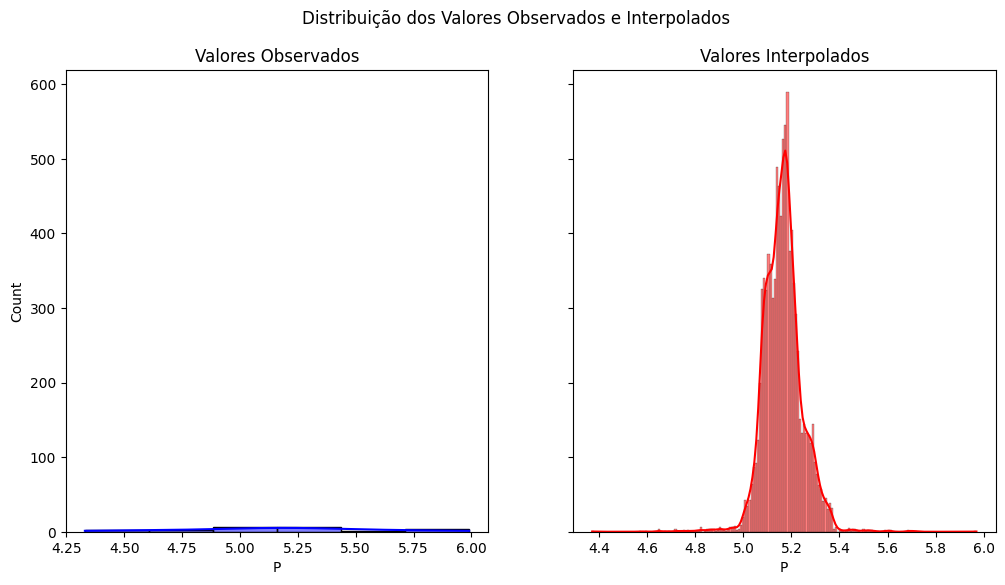

In [191]:
import seaborn as sns
def visualize_interpolation_evaluation_histogram(interpolated_values, observed_values):
    """
    Função para visualizar a qualidade da interpolação através de histogramas dos valores interpolados e observados.

    Parâmetros:
        interpolated_values (array-like): Valores interpolados.
        observed_values (array-like): Valores observados (reais).

    Retorna:
        None (exibe os gráficos).
    """
    # Criar figura com subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    # Plotar histograma dos valores observados
    sns.histplot(observed_values, ax=axes[0], color='blue', kde=True)
    axes[0].set_title('Valores Observados')

    # Plotar histograma dos valores interpolados
    sns.histplot(interpolated_values, ax=axes[1], color='red', kde=True)
    axes[1].set_title('Valores Interpolados')

    # Adicionar título geral
    fig.suptitle('Distribuição dos Valores Observados e Interpolados')

    # Mostrar os gráficos
    plt.show()

# Visualize the interpolation quality for the 'N' column
visualize_interpolation_evaluation_histogram(map2_universal_interpolated_df['P'], map2_nutrients_df['P'])

In [ ]:
# %pip install scikit-gstat

In [50]:
# %pip install pykrige
